In [1]:
import theano
from theano import tensor as T
import lasagne
from lasagne.layers import *
from lasagne.objectives import *
from lasagne.nonlinearities import *
import gym
import numpy as np
from skimage.color import rgb2gray
import cPickle as pickle

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 1: Tesla K40c (CNMeM is disabled, cuDNN 5004)


In [2]:
def q_net(env):
    height, width, nchannels = env.observation_space.shape
    nchannels = 4 # we convert to black and white and use 4 prev frames
    l_in = InputLayer((None, nchannels, height, width))
    l_conv = Conv2DLayer(l_in, num_filters=32, filter_size=3, stride=2)
    l_conv2 = Conv2DLayer(l_conv, num_filters=64, filter_size=3, stride=2)
    l_conv3 = Conv2DLayer(l_conv2, num_filters=96, filter_size=3, stride=2)
    l_conv4 = Conv2DLayer(l_conv3, num_filters=128, filter_size=3, stride=2)
    l_dense = DenseLayer(l_conv4, num_units=env.action_space.n)
    return l_dense

In [3]:
X = T.tensor4('X')
y = T.fmatrix('y') # this is a row column
action_mask = T.fmatrix('action_mask')

In [4]:
env = gym.make('Pong-v0')
l_out = q_net(gym.make('Pong-v0'))
print count_params(l_out)
for layer in get_all_layers(l_out):
    print layer, layer.output_shape

[2017-03-19 10:01:06,037] Making new env: Pong-v0
[2017-03-19 10:01:06,104] Making new env: Pong-v0


268742
<lasagne.layers.input.InputLayer object at 0x7f4545429b90> (None, 4, 210, 160)
<lasagne.layers.conv.Conv2DLayer object at 0x7f4545429d90> (None, 32, 104, 79)
<lasagne.layers.conv.Conv2DLayer object at 0x7f4544ee1310> (None, 64, 51, 39)
<lasagne.layers.conv.Conv2DLayer object at 0x7f4544ee1690> (None, 96, 25, 19)
<lasagne.layers.conv.Conv2DLayer object at 0x7f4544ee1a10> (None, 128, 12, 9)
<lasagne.layers.dense.DenseLayer object at 0x7f4544ee1d90> (None, 6)


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
#plt.imshow(env.step(0)[0])

In [11]:
net_out = get_output(l_out, X)
loss = ( y - (action_mask*net_out).sum(axis=1, keepdims=True) )**2
loss = loss.mean()

In [12]:
out_fn = theano.function([X], net_out)

In [13]:
params = get_all_params(l_out, trainable=True)
params

[W, b, W, b, W, b, W, b, W, b]

In [14]:
updates = lasagne.updates.rmsprop(loss, params, learning_rate=0.1)

In [15]:
train_fn = theano.function([X,y,action_mask], loss, updates=updates)

--------

In [3]:
def eps_greedy_action(phi_t, eps=0.1):
    """
    phi_t: the pre-processed image for this time step
    """
    if np.random.random() <= eps:
        return env.action_space.sample()
    else:
        action_dist = out_fn(phi_t[np.newaxis])
        best_action = np.argmax(action_dist, axis=1)[0]
        return best_action 

In [4]:
env = gym.make('Pong-v0')
env.reset()
# set up replay buffer and image buffers
buf_maxlen = 4
buf = []
buf_idx = []
experience = []
gamma = 1
mb_size = 4
eps = 1.0
for t in range(10000):
    # if the buffer is not at max length, do random actions
    # to fill it up
    if len(buf) != buf_maxlen:
        a_t = env.action_space.sample()
        x, _, _, _ = env.step(a_t)
        buf.append(rgb2gray(x))
        buf_idx.append(t)
    else:
        # phi_t is going to be the 4 most recent frames
        phi_t = np.asarray([
            buf[(t-1-3)%len(buf)], 
            buf[(t-1-2)%len(buf)], 
            buf[(t-1-1)%len(buf)], 
            buf[(t-1-0)%len(buf)]
        ]).astype("float32")
        debug_t = [buf_idx[(t-1-3)%len(buf_idx)], 
                   buf_idx[(t-1-2)%len(buf_idx)], 
                   buf_idx[(t-1-1)%len(buf_idx)], 
                   buf_idx[(t-1-0)%len(buf_idx)]]
        # with probability eps, select a random action
        #a_t = env.action_space.sample()
        a_t = eps_greedy_action(phi_t, eps=eps)
        # execute action a_t in emulator and observe reward r_t and image x_t+1
        x_t1, r_t, is_done, info = env.step(a_t)
        # insert x_t+1 into the buffer, then grab the next
        # 4 most recent frames
        if not is_done:
            buf[ (t) % len(buf) ] = rgb2gray(x_t1)
            buf_idx[ (t) % len(buf) ] = t
            phi_t1 = np.asarray([
                buf[(t-3)%len(buf)], 
                buf[(t-2)%len(buf)], 
                buf[(t-1)%len(buf)], 
                buf[(t-0)%len(buf)]
            ]).astype("float32")
            debug_t1 = [buf_idx[(t-3)%len(buf_idx)], 
                       buf_idx[(t-2)%len(buf_idx)], 
                       buf_idx[(t-1)%len(buf_idx)], 
                       buf_idx[(t-0)%len(buf_idx)]]
        else:
            phi_t1 = phi_t
        #print debug_t, debug_t1
        # add this tuple to the experience buffer
        experience.append( {"phi_t":phi_t, "a_t":a_t, "r_t":r_t, "phi_t1":phi_t1, "is_done":is_done} )
        
        if len(experience) > mb_size:
            # sample from random experience from the buffer
            idxs = [i for i in range(0, len(experience))]
            np.random.shuffle(idxs)
            rand_transitions = [ experience[idx] for idx in idxs[0:mb_size] ]
            phi_t1_minibatch = np.asarray(
                [ rand_transitions[i]["phi_t1"] for i in range(len(rand_transitions)) ]).astype("float32")
            qvalues_minibatch = out_fn(phi_t1_minibatch)
            max_qvalues_minibatch = np.max(qvalues_minibatch,axis=1)
            y_minibatch = []
            for i in range(qvalues_minibatch.shape[0]):
                if rand_transitions[i]["is_done"]:
                    y_minibatch.append([rand_transitions[i]["r_t"]])
                else:
                    y_minibatch.append([rand_transitions[i]["r_t"]+gamma*max_qvalues_minibatch[i]])
            y_minibatch = np.asarray(y_minibatch).astype("float32")

            #print qvalues_minibatch
            #print y_minibatch
            
            mask_minibatch = np.zeros(qvalues_minibatch.shape).astype("float32")
            for i in range(qvalues_minibatch.shape[0]):
                mask_minibatch[ i, np.argmax(qvalues_minibatch[i]) ] = 1.
                
            #print mask_minibatch
            
            #print "qvalues_minibatch", qvalues_minibatch.shape
            #print "y_minibatch", y_minibatch.shape
            #print "mask_minibatch", mask_minibatch.shape
            #print "phi_t1_minibatch", phi_t1_minibatch.shape
            
            this_loss = train_fn(phi_t1_minibatch, y_minibatch, mask_minibatch)
            print this_loss
            
            #print test_fn(phi_t1_minibatch, mask_minibatch)
            
            #break

[2017-03-19 23:17:55,395] Making new env: Pong-v0


NameError: name 'out_fn' is not defined

----

In [190]:
eps_dec_factor = (1 - 0.1) / 10
for t in range(11):
    curr_eps = 1 - (t*eps_dec_factor)
    print curr_eps

1.0
0.91
0.82
0.73
0.64
0.55
0.46
0.37
0.28
0.19
0.1


In [287]:
eps_max, eps_min, thresh = 1.0, 0.1, 1000000.0
eps_dec_factor = (eps_max - eps_min) / thresh
eps_max - ((1000*1000)*eps_dec_factor)

0.09999999999999998

In [308]:
?set_all_param_values

In [2]:
class DeepQ():
    def _q_net(self, env):
        height, width, nchannels = env.observation_space.shape
        nchannels = 4 # we convert to black and white and use 4 prev frames
        l_in = InputLayer((None, nchannels, height, width))
        l_conv = Conv2DLayer(l_in, num_filters=32, filter_size=3, stride=2)
        l_conv2 = Conv2DLayer(l_conv, num_filters=64, filter_size=3, stride=2)
        l_conv3 = Conv2DLayer(l_conv2, num_filters=96, filter_size=3, stride=2)
        l_conv4 = Conv2DLayer(l_conv3, num_filters=128, filter_size=3, stride=2)
        l_dense = DenseLayer(l_conv4, num_units=env.action_space.n)
        return l_dense
    def __init__(self, env):
        self.env = env
        self.l_out = self._q_net(self.env)
        # theano variables
        X = T.tensor4('X')
        y = T.fmatrix('y')
        action_mask = T.fmatrix('action_mask')
        # loss
        net_out = get_output(self.l_out, X)
        loss = ( y - (action_mask*net_out).sum(axis=1, keepdims=True) )**2
        loss = loss.mean()
        # theano functions
        self.q_fn = theano.function([X], net_out)
        params = get_all_params(self.l_out, trainable=True)
        updates = lasagne.updates.rmsprop(loss, params, learning_rate=0.1)
        self.train_fn = theano.function([X,y,action_mask], loss, updates=updates)
    def _preprocess_frame(self, img):
        return rgb2gray(img)
    def _eps_greedy_action(self, phi_t, eps=0.1):
        """
        phi_t: the pre-processed image for this time step
        """
        if np.random.random() <= eps:
            return self.env.action_space.sample()
        else:
            action_dist = self.q_fn(phi_t[np.newaxis])
            best_action = np.argmax(action_dist, axis=1)[0]
            return best_action 
    def _save_as_pickle(self, arr, out_file):
        with open(out_file,"w") as f:
            pickle.dump(arr, f, pickle.HIGHEST_PROTOCOL)
    def load_weights_from(self, in_file):
        weights = pickle.load(open(in_file))
        set_all_param_values(self.l_out, weights)   
    def _save_weights_to(self, out_file):
        self._save_as_pickle(get_all_param_values(self.l_out), out_file)
    def train(self, 
              gamma=0.95,
              eps=1.,
              max_t=100000,
              max_ep=100, 
              max_frames=None,
              update_q=True,
              batch_size=32,
              save_experience_to=None,
              save_outfile_to=None,
              debug=False):
        """
        :gamma: discount factor
        :eps: initial eps factor for exploration
        :max_t: maximum # of time steps per episode before it ends
        :max_ep: maximum # of episodes before termination of this fn
        :max_frames: maximum # of frames to see before termination of this fn
        :update_q: backprop through Q fn
        :batch_size: batch size for updates
        :save_experience_to: save most recent experience to pkl file
        :debug:
        """
        f = open(save_outfile_to, "wb") if save_outfile_to != None else None
        experience, experience_maxlen = [], 20000
        tot_frames = 0
        eps_max, eps_min, thresh = eps, 0.1, 1000000.0
        eps_dec_factor = (eps_max - eps_min) / thresh
        curr_eps = eps_max
        for ep in range(max_ep):
            losses = []
            buf, buf_maxlen = [], 4
            env.reset()
            a_t = self.env.action_space.sample()
            phi_t = None
            buf_was_full = False
            for t in range(max_t):
                # with probability eps, select a random action a_t
                # otherwise select it from the Q function
                # NOTE: because we take a different action every 4
                # frames, only re-assign a_t when the buf was previously
                # full
                if buf_was_full:
                    # from deep-q paper: anneal eps from 1 to 0.1
                    # over the course of 1m iterations
                    if tot_frames <= thresh:
                        curr_eps = eps_max - (tot_frames*eps_dec_factor)
                    else:
                        curr_eps = eps_min
                    a_t = self._eps_greedy_action(phi_t, eps=curr_eps)
                    buf_was_full = False
                    #if debug:
                    #    print "%i: make new a_t" % t
                else:
                    a_t = a_t
                    #if debug:
                    #    print "%i: keep current a_t" % t
                    #print "buf_was_not_Full"
                # execute action a_t in emulator and observe
                # reward r_t and image x_t+1
                x_t1, r_t, is_done, info = env.step(a_t)
                buf.append(self._preprocess_frame(x_t1))
                tot_frames += 1
                #print len(buf)
                # store transition (phi_t, a_t, r_t, phi_t1 into D)
                # NOTE: this requires two conditions to be met:
                # - that phi_t != None (it is None on the first execution of the
                #   below if statement)
                # - that phi_t exists (which is only the case when the buffer is full)
                if len(buf) == buf_maxlen:
                    phi_t1 = np.asarray(buf, dtype="float32")
                    if phi_t != None:
                        tp = {"phi_t":phi_t, "a_t":a_t, "r_t":r_t, "phi_t1":phi_t1, "is_done":is_done}
                        if len(experience) != experience_maxlen:
                            experience.append(tp)
                        else:
                            experience[ tot_frames % len(experience) ] = tp   
                    phi_t = phi_t1
                    buf = []
                    buf_was_full = True
                    if is_done:
                        out_str = "episode %i took %i iterations, avg loss = %f, curr_eps = %f" % \
                            (ep+1, t+1, np.mean(losses), curr_eps)
                        print out_str
                        if f != None:
                            f.write(out_str + "\n"); f.flush()
                        #self._save_as_pickle(experience, "/storeSSD/cbeckham/deleteme.pkl")
                        self._save_weights_to("weights.pkl")
                        break

                    if len(experience) > batch_size and update_q:

                        # sample from random experience from the buffer
                        idxs = [i for i in range(0, len(experience))] # index into ring buffer
                        np.random.shuffle(idxs)
                        rand_transitions = \
                            [ experience[idx] for idx in idxs[0:batch_size] if experience[idx] != None ]
                        phi_t1_minibatch = np.asarray(
                            [ rand_transitions[i]["phi_t1"] for i in range(len(rand_transitions)) ]).astype("float32")
                        qvalues_minibatch = self.q_fn(phi_t1_minibatch)
                        max_qvalues_minibatch = np.max(qvalues_minibatch,axis=1)
                        y_minibatch = []
                        for i in range(qvalues_minibatch.shape[0]):
                            if rand_transitions[i]["is_done"]:
                                y_minibatch.append([rand_transitions[i]["r_t"]])
                            else:
                                y_minibatch.append([rand_transitions[i]["r_t"]+gamma*max_qvalues_minibatch[i]])
                        y_minibatch = np.asarray(y_minibatch).astype("float32")
                        #print qvalues_minibatch
                        #print y_minibatch
                        mask_minibatch = np.zeros(qvalues_minibatch.shape).astype("float32")
                        for i in range(qvalues_minibatch.shape[0]):
                            mask_minibatch[ i, np.argmax(qvalues_minibatch[i]) ] = 1.
                        #print mask_minibatch
                        #print "qvalues_minibatch", qvalues_minibatch.shape
                        #print "y_minibatch", y_minibatch.shape
                        #print "mask_minibatch", mask_minibatch.shape
                        #print "phi_t1_minibatch", phi_t1_minibatch.shape
                        this_loss = self.train_fn(phi_t1_minibatch, y_minibatch, mask_minibatch)
                        losses.append(this_loss)
                    
                if tot_frames >= max_frames:
                    #return experience, losses
                    return
                    
            #return losses
        #return experience, losses
        return

In [3]:
env = gym.make('Pong-v0')
qq = DeepQ(env)

[2017-03-20 07:51:56,468] Making new env: Pong-v0


In [305]:
qq.train(max_t=100000, max_ep=100000, 
         max_frames=10000000, update_q=True, debug=True)

/home/cbeckham/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:115: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


episode 1 took 1168 iterations, avg loss = 0.076770, curr_eps = 0.998952
episode 2 took 1368 iterations, avg loss = 0.020711, curr_eps = 0.997721
episode 3 took 1100 iterations, avg loss = 0.025091, curr_eps = 0.996731
episode 4 took 1248 iterations, avg loss = 0.023814, curr_eps = 0.995608
episode 5 took 1172 iterations, avg loss = 0.025043, curr_eps = 0.994553
episode 6 took 1248 iterations, avg loss = 0.022408, curr_eps = 0.993430
episode 7 took 1324 iterations, avg loss = 0.022443, curr_eps = 0.992238
episode 8 took 1568 iterations, avg loss = 0.021899, curr_eps = 0.990827
episode 9 took 1436 iterations, avg loss = 0.021735, curr_eps = 0.989535
episode 10 took 1288 iterations, avg loss = 0.020249, curr_eps = 0.988376
episode 11 took 1180 iterations, avg loss = 0.018707, curr_eps = 0.987314
episode 12 took 1200 iterations, avg loss = 0.020485, curr_eps = 0.986234
episode 13 took 1116 iterations, avg loss = 0.021920, curr_eps = 0.985229
episode 14 took 1120 iterations, avg loss = 0.0

MemoryError: 

In [6]:
env = gym.make('Pong-v0')
qq = DeepQ(env)
qq.load_weights_from("weights.pkl")

[2017-03-19 23:18:05,317] Making new env: Pong-v0


In [ ]:
qq.train(max_t=100000, max_ep=100000, 
         max_frames=10000000, update_q=True, debug=True, eps=0.93)

/home/cbeckham/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:118: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


episode 1 took 1088 iterations, avg loss = 0.020614, curr_eps = 0.929100
episode 2 took 1140 iterations, avg loss = 0.017055, curr_eps = 0.928154
episode 3 took 1096 iterations, avg loss = 0.019803, curr_eps = 0.927244
episode 4 took 1304 iterations, avg loss = 0.017019, curr_eps = 0.926162
episode 5 took 1424 iterations, avg loss = 0.020158, curr_eps = 0.924980
episode 6 took 1256 iterations, avg loss = 0.019469, curr_eps = 0.923938
episode 7 took 1368 iterations, avg loss = 0.018237, curr_eps = 0.922802
episode 8 took 1412 iterations, avg loss = 0.019975, curr_eps = 0.921630
episode 9 took 1088 iterations, avg loss = 0.017066, curr_eps = 0.920727
episode 10 took 1424 iterations, avg loss = 0.017958, curr_eps = 0.919545
episode 11 took 1132 iterations, avg loss = 0.019393, curr_eps = 0.918606
episode 12 took 1140 iterations, avg loss = 0.020026, curr_eps = 0.917660
episode 13 took 1084 iterations, avg loss = 0.020718, curr_eps = 0.916760
episode 14 took 1204 iterations, avg loss = 0.0

In [4]:
env = gym.make('Pong-v0')
qq = DeepQ(env)
qq.load_weights_from("weights.pkl.2")

[2017-03-20 07:52:22,600] Making new env: Pong-v0


In [ ]:
qq.train(max_t=100000, max_ep=100000, 
         max_frames=1000000, update_q=True, debug=True, eps=0.46)

/home/cbeckham/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:118: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


episode 1 took 1112 iterations, avg loss = 0.016778, curr_eps = 0.459601
episode 2 took 1352 iterations, avg loss = 0.015671, curr_eps = 0.459114
episode 3 took 1556 iterations, avg loss = 0.011034, curr_eps = 0.458554
episode 4 took 1164 iterations, avg loss = 0.014009, curr_eps = 0.458135
episode 5 took 1104 iterations, avg loss = 0.013409, curr_eps = 0.457738
episode 6 took 1020 iterations, avg loss = 0.011442, curr_eps = 0.457371
episode 7 took 1024 iterations, avg loss = 0.014951, curr_eps = 0.457002
episode 8 took 1220 iterations, avg loss = 0.016242, curr_eps = 0.456563
episode 9 took 1180 iterations, avg loss = 0.014137, curr_eps = 0.456138
episode 10 took 1120 iterations, avg loss = 0.017249, curr_eps = 0.455735
episode 11 took 1224 iterations, avg loss = 0.018135, curr_eps = 0.455294
episode 12 took 1104 iterations, avg loss = 0.015455, curr_eps = 0.454897
episode 13 took 1172 iterations, avg loss = 0.016802, curr_eps = 0.454475
episode 14 took 1084 iterations, avg loss = 0.0

Notes:
* On my Macbook, one episode (1150 frames) took 12 sec. This means to preocess 10M frames, it will take ~ 28 hrs. ??
* https://jkjung-avt.github.io/dqn-pong/ says it took 'less than a day' on a 1080

In [236]:
for idx in range(len(tmp1)):
    if tmp1[idx]["r_t"] == -1:
        print idx

65
88
187
254
277
374
398
432
501
643
648
728
821
904
928
987
998


-1.0


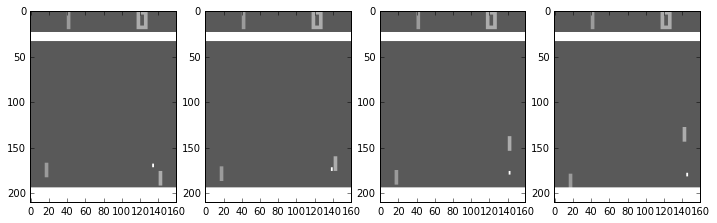

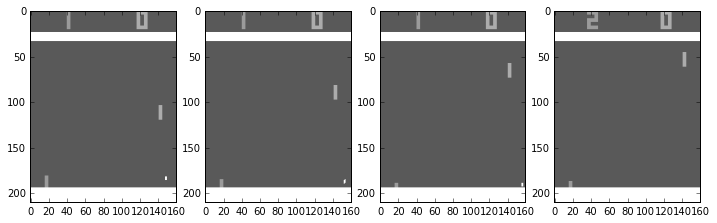

In [238]:
idx=904
subplot_phi(tmp1[idx]["phi_t"])
print tmp1[idx]["r_t"]
subplot_phi(tmp1[idx]["phi_t1"])

In [138]:
def subplot_phi(phi):
    """
    :phi: of shape (4, H, W)
    """
    assert phi.shape[0] == 4
    plt.figure(figsize=(12,7))
    plt.subplot(1,4,1)
    plt.imshow(phi[0],cmap="gray")
    plt.subplot(1,4,2)
    plt.imshow(phi[1],cmap="gray")
    plt.subplot(1,4,3)
    plt.imshow(phi[2],cmap="gray")
    plt.subplot(1,4,4)
    plt.imshow(phi[3],cmap="gray")
    